# Word2Vec
...

## Implementation
This implementation of two Word2Vec models; Continuous Bag of Words(CBoW) and Skipgram.

**Dimensions** 
- `b` : batch size
- `h` : embedding(or projection) size
- `w` : window size
- `v` : vocabulary size
### imports

In [71]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import trange
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Preperation
#### Download nltk packages

In [ ]:
nltk.download('all')

#### Load and Preprocess English Corpus Toy Data(tokenize words, remove stopwords)

In [73]:
with open("./toy_data/peter.txt", "r", encoding="utf8") as f:
    txt = f.read()

stop_words = set(stopwords.words('english'))
word_tokens = word_tokenize(txt)

word_tokens_preprocessed = [word for word in word_tokens if word not in stop_words]

#### Custom Dataset

In [74]:
class Word2VecDataset(Dataset):
    def __init__(self, words, window_size):
        super(Word2VecDataset, self).__init__()
        self.words = words

        self.idx2word = sorted(set(words))
        self.word2idx = {w:i for i, w in enumerate(self.idx2word)}
        self.wordindecies = [self.word2idx[i] for i in self.words]
        self.vocab_size = len(self.idx2word)
        
        self.window_size = window_size
        
    def __len__(self):
        return len(self.pair)

    def onehot(self, index):
        return (torch.arange(self.vocab_size)==self.wordindecies[index]).to(torch.float)

    def __getitem__(self, index):
        i, j = self.pair[index]
        return torch.tensor(i, dtype=torch.int), self.onehot(j)
    

#### CBoW Dataset, DataLoader
suppose
- sentence : **'a b c d e'**
- window size : 2
- center word : c

then

Input|Target
|:--:|:----:|
a, b, d, e| c

<br />

- (Temporary Measure) Center word in the edge of sentences will cause window size to srink, which cause errors in batching process(in `DataLoader`). In this implementation, I wasn't able to find an elegant work-around and had to fill the missing parts with something else.\
For example shown above, if we choose center word 'a', the datapoint should look like

    b, c| a
    |---|--|

    But since this cause errors, for now the empty window is filled with center word as such.

    a, a, b, c| a
    |---------|--|

In [75]:
class CBoWDataset(Word2VecDataset):
    def __init__(self, words, window_size=2):
        super(CBoWDataset, self).__init__(words, window_size)
        self.pair = [([self.wordindecies[i+j] if 0<i+j<len(words) else self.wordindecies[i] for j in range(-window_size, window_size+1) if j], word) 
                        for i, word in enumerate(self.wordindecies)]
        
cbow_dataset = CBoWDataset(word_tokens_preprocessed)
cbow_loader = DataLoader(cbow_dataset, 100)

#### Skipgram Dataset, DataLoader
suppose (same as above)
- sentence : **'a b c d e'**
- window size : 2
- center word : c

then

Input|Target
|:--:|:----:|
c|a
c|b
c|d
c|e

In [76]:
class SkipgramDataset(Word2VecDataset):
    def __init__(self, words, window_size=2):
        super(SkipgramDataset, self).__init__(words, window_size)
        self.pair = [(word, self.wordindecies[i+j]) for i, word in enumerate(self.wordindecies) for j in range(-window_size, window_size+1) if j and 0<i+j<len(words)]
        
skipgram_dataset = SkipgramDataset(word_tokens_preprocessed)
skipgram_loader = DataLoader(skipgram_dataset, 100)

### Model
: `Word2VecModel` implements basic structure of Word2Vec Models where it wraps a encoder and a decoder.

- `nn.Embedding(vocab_size, embed_size)` : Used when input is a one-hot encoding. Instead of feeding one-hot to a `nn.Linear` layer, `nn.Embedding` takes in an index and returns a vector(or embedding). The embedding has `require_grad=True` so it can update the embedding. `nn.Embedding` layer is essentially indexes a linear layer, where it takes an index number and returns a embedding. `nn.Embedding` layer is essentially indexes a linear layer.
![](asset/track.PNG)

In [77]:
class Word2VecModel(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Word2VecModel, self).__init__()
        
        self.encoder = nn.Embedding(vocab_size, embed_size)
        self.decoder = nn.Linear(embed_size, vocab_size)
        

#### CBoW Model
input|<span style="font-weight:normal">Input Bag of Words `(torch.tensor: (b, 2*w))`</span>
|:-------:|:---------------------------------------------------------------------------------|
**output**|Output Center Word `(torch.tensor: (b, v))`

: `CBoWModel` is fed **neighboring words** and trained to **minimize loss between the output word and the center word**. The neightboring words are fed at once and averaged in the projection layer, then outputed.

<img src="asset/13-Word2Vec-cbow-diagram.png" alt="drawing" width="500"/>

[image source: https://lilianweng.github.io/posts/2017-10-15-word-embedding/]

In [78]:
class CBoWModel(Word2VecModel):
    def __init__(self, vocab_size, projection_layer):
        super(CBoWModel, self).__init__(vocab_size, projection_layer)
        
    def forward(self, x):
        x = sum(self.encoder(i) for i in x.T)/len(x)
        x = self.decoder(x)
        return x

#### Skipgram Model
input|<span style="font-weight:normal">Input Center Word `(torch.tensor: (b,))`</span>
|:-------:|:---------------------------------------------------------------------------------|
**output**|Output neighbor Word `(torch.tensor: (b, v))`

: `SkipgramModel` is fed **center word** and trained to **minimize loss between the output word and the neighboring words**. The neighboring words are each compared with the output one by one.

<img src="asset/13-Word2Vec-skipgram-diagram.png" alt="drawing" width="500"/>

[image source: https://lilianweng.github.io/posts/2017-10-15-word-embedding/]

In [79]:
class SkipgramModel(Word2VecModel):
    def __init__(self, vocab_size, projection_layer):
        super(SkipgramModel, self).__init__(vocab_size, projection_layer)
        
    def forward(self, x):
        x = self.encoder(x)    
        x = self.decoder(x)
        return x

#### Declare Model

In [80]:
cbow = CBoWModel(cbow_dataset.vocab_size, 200).to(device)
skipgram = SkipgramModel(skipgram_dataset.vocab_size, 200).to(device)

### Training setup
#### Trainer Function
We make training process as a funtion to use it for CBoW and Skipgram models. Both training setup and training loop is contained in this function.

In [81]:
def train(model, word_dataset, word_loader):
    loss = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 1000

    losses = []
    pbar = trange(epochs)
    for epoch in pbar:
        ls = acc = 0
        for idx, label in word_loader:
            idx, label, = (i.to(device) for i in (idx, label,))
            output = model(idx)
            optimizer.zero_grad()
            L = loss(output, label)
            L.backward()
            optimizer.step()

            out = torch.argmax(output.detach(), dim=1)
            lab = torch.argmax(label.detach(), dim=1)
            acc += torch.sum(out==lab).item()
            ls += L.detach().item()/len(word_loader)

        pbar.set_description(f"loss: {ls}, acc: {acc/len(word_dataset)*100}")

#### Embedding Distribution Plotter Function

In [82]:
def plotWord(model:Word2VecModel, worddata: Word2VecDataset):
    fig, ax = plt.subplots()
    x = torch.arange(0, worddata.vocab_size)
    y = model.encoder(x.to(device)).cpu().detach()
    ax.scatter(*(y[:, :2].T), s=3)

    for word, (x, y) in zip(worddata.idx2word, y[:, :2]):
        ax.annotate(word, (x, y), fontsize=8)
    plt.show()

### Training
#### Training CBoW

In [83]:
train(cbow, cbow_dataset, cbow_loader)

loss: 0.052445798326516524, acc: 99.44979367262724: 100%|██████████| 1000/1000 [00:19<00:00, 50.97it/s]


#### CBoW Embedding Distribution

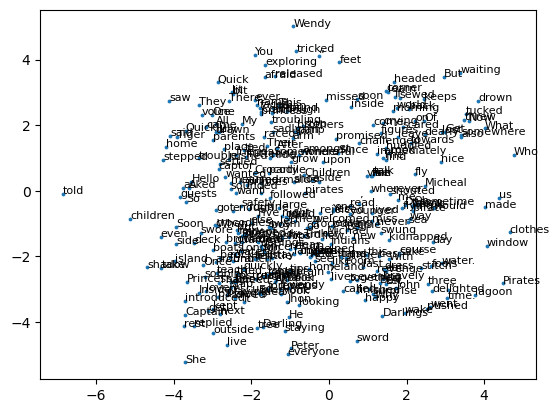

In [84]:
plotWord(cbow, cbow_dataset)

#### Training Skipgram

In [85]:
train(skipgram, skipgram_dataset, skipgram_loader)

loss: 2.408242710705461, acc: 19.482758620689655: 100%|██████████| 1000/1000 [01:10<00:00, 14.27it/s]


#### Skipgram Embedding Distribution

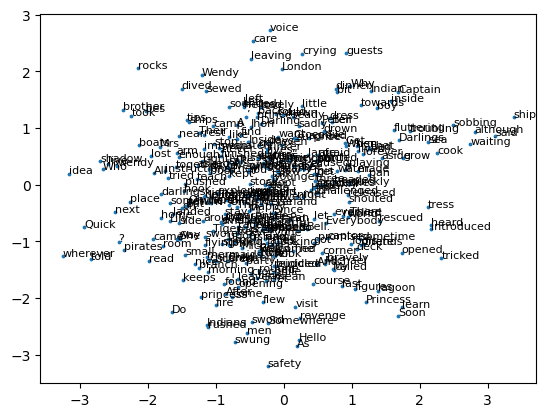

In [86]:
plotWord(skipgram, skipgram_dataset)